In [1]:
import os

import tensorflow as tf

from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

import numpy as np
from matplotlib import pyplot as plt

In [29]:
def compose_f(functions, x):
    out = x
    
    for f in functions:
        out = f(out)
    
    return out

In [7]:
def conv_layer(n_filters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'):
    """ Just alias for keras.layers.Conv2D """
    
    return Conv2D(n_filters, size, activation = activation, padding = padding, kernel_initializer = kernel_initializer)

In [10]:
def pool_layer(pool_size=(2, 2)):
    return MaxPooling2D(pool_size=pool_size)

In [35]:
def contracting_block(n_filters, x):
    x = conv_layer(n_filters, 3)(conv_layer(n_filters, 3)(x))
    skip_conn = x  # save to concat in corresponding skip connection later
    
    x = pool_layer()(x)
    return x, skip_conn

In [37]:
def contracting_path(x, start_layers=64, n_layers=4):
    current_n_layers = start_layers
    skip_conns = []
    
    for _ in range(n_layers):
        x, skip_conn = contracting_block(current_n_layers, x)
        
        skip_conns.append(skip_conn)
        current_n_layers *= 2
    
    # todo: dropout ?
    return x, skip_conns

In [38]:
def upconv_block(x, n_filters, size, up_sampling_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'):
    x = UpSampling2D(size = up_sampling_size)(x)
    x = conv_layer(n_filters, size)(x)
    return x

In [41]:
def expanding_block(n_filters, x, skip_conn):
    x = upconv_block(x, n_filters, 2, (2,2))  # up-convolution
    x = concatenate([skip_conn, x], axis=3)  # concat in 3rd dim
    x = conv_layer(n_filters, 3)(x)
    x = conv_layer(n_filters, 3)(x)
    return x

In [44]:
def expanding_path(x, skip_conns, start_layers=512):
    current_n_layers = start_layers
    
    for skip_conn in reversed(skip_conns):
        x = expanding_block(current_n_layers, x, skip_conn)
        
        current_n_layers /= 2
    
    return x

In [52]:
# todo batchnorm

def _unet(input_size = (256, 256, 1)):
    x = Input(input_size)
    inputs = x
    
    x, skip_conns = contracting_path(x)
    x = conv_layer(1024, 3)(conv_layer(1024, 3)(x))  # todo: dropout ?
    
    x = expanding_path(x, skip_conns)
    
    x = conv_layer(2, 3)(x)  # output segmentation map
    x = conv_layer(1, 1, activation = 'sigmoid')(x)
    
    outputs = x
    return inputs, outputs

In [125]:
def unet(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy']):
    inputs, outputs = _unet()
    
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()
    
    return model

In [115]:
def get_data(imgs_path, masks_path, im_size, train=True):
    """ Get and resize train images and masks """

    im_width, im_height = im_size
    list_imgs = next(os.walk(imgs_path))[2]
    X = np.zeros((len(list_imgs), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(list_imgs), im_height, im_width, 1), dtype=np.float32)
    
    for i, img_name in enumerate(list_imgs):
        mask_name = img_name.replace('img_', 'mask_')
        
        # load images
        img = img_to_array(load_img(imgs_path + '/' + img_name, grayscale=True))
        img = resize(img, (im_height, im_width, 1), mode='constant', preserve_range=True)

        # load masks
        if train:
            mask = img_to_array(load_img(masks_path + '/' + mask_name, grayscale=True))
            mask = resize(mask, (im_height, im_width, 1), mode='constant', preserve_range=True)

        # save images
        X[i, ..., 0] = img.squeeze() / 255
        if train:
            y[i] = mask / 255

    if train:
        return X, y
    
    return X

In [119]:
# get data
data_path = '/home/stefano/Scuola/now/rp/martin/attila/data/toy/fluo'
X, y = get_data(data_path + '/images', data_path + '/masks', (256, 256), train=True)

In [122]:
# split train and test 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2020)

<ipython-input-123-71db3b49fbe8>:9: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])


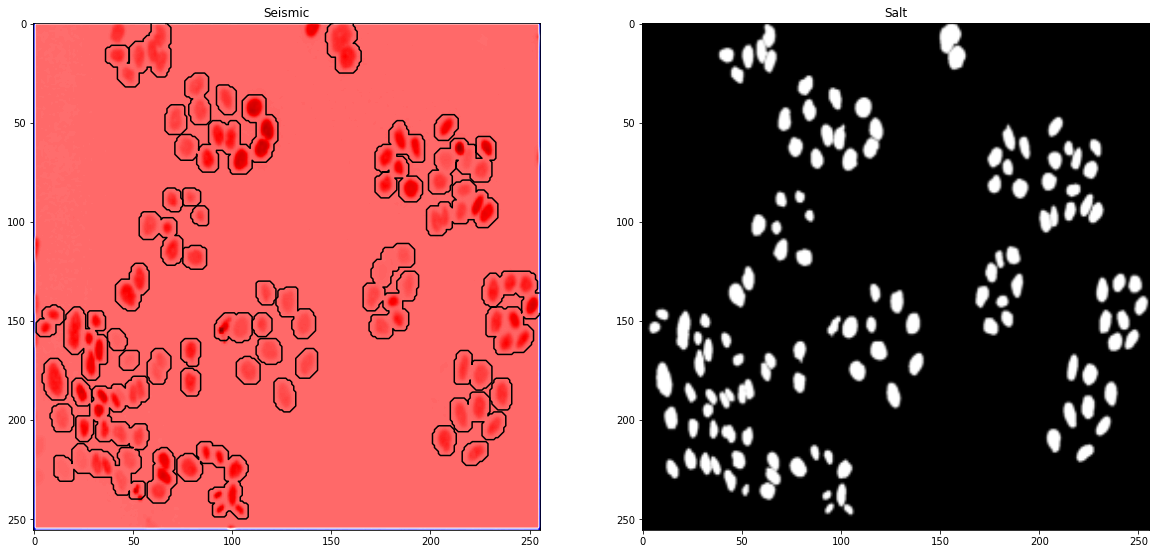

In [123]:
# check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

In [ ]:
model = unet()

# todo callbacks
# results = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid))

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 256, 256, 64) 640         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 256, 256, 64) 36928       conv2d_189[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_36 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_188[0][0]                 
_______________________________________________________________________________________